> 
FIGURE A1.4:  Examples of five neurons (5 columns) -- one for OT, one for CN, one for CV, one for CX and one for CO For each neuron, the first row shows the stimulus tuning curve of the neuron. Second row shows the Same curve fitted by Gabor (simple or complex), third row showed the same curve fitted by GLM, forth row showed the same curve fitted by OMP (optional), and fifth row showed the same curve fitted by CNN.  The six row showed the visualization of CNN, started with multiple 3 initial conditions. The seventh row showed top 10 or 20 distinct stimuli (colored those above half height). 
>
>
> Given your most Figure comparing the different models,  maybe this Figure A1.4 can be simplified — i.e. don’t really need the GLM and Gabor fit of the tuning curves, CNN fit example would be enough.  But visualization is still good as a summary description of the model to give intuitive impression. Can discuss tomorrow.
>
> Tai Sing.

For the thesis proposal, I should not include the visualization part, which is kind of cheating (using 192 channel model instead of 12 channel one). For grant proposal, it's OK.

In [1]:
%matplotlib inline
import numpy as np
import h5py
import os.path
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
import h5py
from scipy.stats import pearsonr, spearmanr
from skimage.io import imsave

In [2]:
from torchvision.utils import make_grid
from torch import FloatTensor

In [3]:
from tang_jcompneuro import dir_dictionary
from tang_jcompneuro.cell_classification import compute_cell_classification
from tang_jcompneuro.cell_stats import compute_ccmax
from tang_jcompneuro.io import load_image_dataset, load_neural_dataset, load_split_dataset
from tang_jcompneuro.model_fitting_postprocess import load_model_performance

In [4]:
model_dict = OrderedDict()

model_dict['CNN'] = ('cnn', 'b.4')
model_dict['Gabor'] = ('gabor', 'multi,1,2')
model_dict['GLM'] = ('glm', 'gqm.4_poisson')
dataset_to_check = 'MkA_Shape'
subset_to_check = 'all'

In [5]:
neuron_perf_norm_dict = {x: load_model_performance('MkA_Shape', 'all', '100', 0, y[0], y[1],
                                             load_y_test_hat=True, metric='ccnorm_5', squared=True)
                   for x, y in model_dict.items()}
neuron_perf_abs_dict = {x: load_model_performance('MkA_Shape', 'all', '100', 0, y[0], y[1],
                                             load_y_test_hat=True, metric='raw', squared=True)
                   for x, y in model_dict.items()}
y_all_test = load_split_dataset('MkA_Shape', 'all', True, slice(None))[3] 

In [6]:
folder_to_save =os.path.join(dir_dictionary['plots'], 'main', 'demo_fitted_neurons')
os.makedirs(folder_to_save, exist_ok=True)

In [7]:
_get_all_data_cache = dict()
def get_all_data():
    if 'X' not in _get_all_data_cache:
        _get_all_data_cache['X'] = load_image_dataset('Shape_9500', normalize_cnn_format=True)
    if 'y' not in _get_all_data_cache:
        _get_all_data_cache['y'] = load_neural_dataset(dataset_to_check,return_positive=True)
    X, y = _get_all_data_cache['X'], _get_all_data_cache['y']
    assert X.shape == (9500,1,40,40)
    assert y.shape == (9500,1142)
    return X, y

In [8]:
def show_top_stimuli(neuron_idx_this, save_prefix):
    # load actual neuron response
    actual_response_this_ALL = get_all_data()[1][:, neuron_idx_this]
    assert actual_response_this_ALL.shape == (9500,)
    actual_response_sort_idx_ALL = np.argsort(actual_response_this_ALL)[::-1]
    # show top 20 stimuli, 10 x 2.
    X_top_this_ALL = get_all_data()[0][actual_response_sort_idx_ALL[:20]]

    # use torchvision to get a 10 x 2 grid and show it.
    X_top_this_ALL = make_grid(FloatTensor(X_top_this_ALL)[:20], nrow=10, normalize=False, scale_each=False)
    X_top_this_ALL = np.transpose(X_top_this_ALL.numpy(), (1, 2, 0))
    plt.close('all')
    plt.imshow(X_top_this_ALL)
    plt.show()

    # save it.
    imsave(save_prefix+'xtop.png', X_top_this_ALL)

In [9]:
from tang_jcompneuro.cnn import CNN
from torch.backends import cudnn
import time
cudnn.enabled = False  # for deterministic.

from tang_jcompneuro.model_fitting_cnn import (opt_configs_to_explore, models_to_train,
                                               init_config_to_use_fn, train_one_case,
                                               save_one_model)

In [10]:
def imshow_inner(npimg, figsize=(8, 6), save_name=None):
    plt.close('all')
    plt.figure(figsize=figsize)
    img_to_show = np.transpose(npimg.numpy(), (1, 2, 0))
    plt.imshow(img_to_show)
    
    if save_name is not None:
        imsave(save_name, img_to_show)
    
    plt.show()

In [11]:
def train_one_neuron(neuron_idx, save_prefix):
    neuron_idx_start = (neuron_idx//50)*50
    neuron_idx_end = min(neuron_idx_start+50, 1142)
    # from ../supp/rtc_on_specific_neuron.ipynb
    with h5py.File(os.path.join(dir_dictionary['models'], 'cnn', 'b.4',
                                'MkA_Shape', 'all', '100', '0',
                                f'{neuron_idx_start}_{neuron_idx_end}.hdf5'), 'r') as f_out:
        grp_this = f_out[f'/MkA_Shape/all/100/0/cnn/b.4/{neuron_idx}']
        best_config, best_corr_ref = grp_this.attrs['best_config'], grp_this['corr'][()]

    opt_config = opt_configs_to_explore[best_config]
    arch_config = models_to_train['b.4']
#     print(opt_config, arch_config)
    datasets_local = load_split_dataset('MkA_Shape', 'all', True, neuron_idx)
    
    model = CNN(arch_config, init_config_to_use_fn(), mean_response=datasets_local[1].mean(axis=0),
                seed=0,
                scale_hack=None,
                input_size=20,
                )
    
    model.cuda()
    t1 = time.time()
    y_val_cc, y_test_hat, new_cc = train_one_case(model, datasets_local, opt_config,
                                                  seed=2, show_every=1000,
                                                  return_val_perf=True,
                                                  max_epoch=20000)
    t2 = time.time()
    print(t2-t1, 'sec')
    print('ref corr', best_corr_ref, 'current corr', new_cc)
    
    model_save_dir = os.path.join(dir_dictionary['models'], 'cnn_cherrypick', 'MkA_all_0_b4')
    os.makedirs(model_save_dir, exist_ok=True)
    
    
    with h5py.File(os.path.join(model_save_dir, f'{neuron_idx}.hdf5')) as f_out:
        f_out.require_group('model')
        save_one_model(model, f_out['model'])
        # save ref ytest_hat, ytest_cc.
        if 'ytest_hat' not in f_out:
            f_out.create_dataset('ytest_hat', data=y_test_hat)
        if 'corr' not in f_out:
            f_out.create_dataset('corr', data=new_cc)
        # visualize kernels
        
        kernels = f_out['model']['conv.conv0.weight'][...]
        fc_weights = ((f_out['model']['fc.fc.weight'][...])**2).reshape(4,4,4).sum(axis=(1,2))
        # first is channel.
        assert fc_weights.shape == (4,) and np.all(fc_weights>0)
    del model
    
    
    
    imshow_inner(make_grid(FloatTensor(kernels),normalize=True, scale_each=True),
           save_name=save_prefix + 'original_filters.png')
    # use weighted as well
    imshow_inner(make_grid(FloatTensor(kernels*fc_weights[:,np.newaxis,np.newaxis,np.newaxis]),
                           normalize=True, scale_each=False),
           save_name=save_prefix + 'original_filters_weighted.png')

In [12]:
def master_loop():
    cell_class_dict = compute_cell_classification(dataset_to_check,3, readonly=True)
    classes_to_check = ('OT', 'CV', 'CN', 'CRS', 'Other')
    
    cnn_training_map = {
        'OT': 578,
        'CV': 553,
        'CN': 459,
        'CRS': 1079,
        'Other': 4,
    }
    
    cell_to_check_per_class = 10
    # orientation, curve, corner, cross, composition.
    
    
    top_stimulus_in_curve = 300
    
#     r2abs, r2norm, ccmax = load_raw_and_ccnorm_score()
    
    for cell_class in classes_to_check:
        class_label_this = cell_class_dict[cell_class]
        r2abs = neuron_perf_abs_dict['CNN']['corr'].copy()
        r2norm = neuron_perf_norm_dict['CNN']['corr'].copy()
        assert class_label_this.shape == r2abs.shape == r2norm.shape == (1142,)
        print(cell_class, class_label_this.sum())
        
        # then, get all cells in that class, check the top {cell_to_check_per_class} ones in terms of raw score.
        
        # I also need their absolute idx among 1142 neurons.
        index_abs_all = np.flatnonzero(class_label_this)
        scores_this_set_abs = r2abs[class_label_this]
        scores_this_set_norm = r2norm[class_label_this]
        
        # these two are very high. I guess it's fine to just use raw score.
        print(pearsonr(scores_this_set_abs, scores_this_set_norm)[0])
        print(spearmanr(scores_this_set_abs, scores_this_set_norm)[0])
        
        high_index_relative = np.argsort(scores_this_set_abs)[::-1]
        high_index_abs = index_abs_all[high_index_relative]
        scores_this_set_abs_sorted = scores_this_set_abs[high_index_relative]
        scores_this_set_norm_sorted = scores_this_set_norm[high_index_relative]
        
        
        scores_norm_to_check = scores_this_set_norm_sorted[:cell_to_check_per_class]
        scores_abs_to_check = scores_this_set_abs_sorted[:cell_to_check_per_class]
        index_to_check = high_index_abs[:cell_to_check_per_class]
        
        # for each one, load all models' responses and scores.
        assert index_to_check.shape == scores_norm_to_check.shape == scores_abs_to_check.shape == (cell_to_check_per_class,)
        x_axis_range = np.arange(1900)
        
        
        
        for neuron_idx_this_dummy, (neuron_idx_this, score_norm_this, score_abs_this) in enumerate(zip(index_to_check,
                                                                   scores_norm_to_check,
                                                                   scores_abs_to_check)):
            print('dummy', neuron_idx_this_dummy, 'real', neuron_idx_this, 'ccnorm2', score_norm_this,
                 'ccabs2', score_abs_this)
            
            save_prefix = os.path.join(folder_to_save, f'{cell_class}_{neuron_idx_this_dummy}_')
            
            show_top_stimuli(neuron_idx_this, save_prefix)
            

            y_all_test_this = y_all_test[:, neuron_idx_this]
            assert y_all_test_this.shape == (1900,)
            y_all_test_this_sortidx = np.argsort(y_all_test_this)[::-1]
            plt.close('all')
            fig, axes = plt.subplots(len(model_dict),1,sharex=True, sharey=True,squeeze=False,
                                     figsize=(3,4.5))
            for model_idx, model_name in enumerate(model_dict.keys()):
                # load score and response
                y_recon =neuron_perf_norm_dict[model_name]['y_test_hat'][:,neuron_idx_this]
                ccnorm_this = neuron_perf_norm_dict[model_name]['corr'][neuron_idx_this]
                # then plot.
                ax_this = axes[model_idx,0]
                ax_this.plot(x_axis_range, y_all_test_this[y_all_test_this_sortidx], label='raw')
                ax_this.plot(x_axis_range, y_recon[y_all_test_this_sortidx], label='{} {:.2f}'.format(model_name,
                                                                                                       ccnorm_this))
                ax_this.legend(loc='upper right')
                ax_this.set_xlim(0, top_stimulus_in_curve)
                ax_this.set_ylabel('response')
                # put on ccnorm^2 for this neuron.
                #print(neuron_idx_this, score_norm_this, score_abs_this)
            fig.subplots_adjust(top=0.98, bottom=0.05, left=0.18, right=0.95, hspace=0.1, wspace=0.1)
            fig.savefig(save_prefix+'curves.pdf', dpi=300)
            plt.show()
            
            
            # train model for CNN
            if neuron_idx_this == cnn_training_map[cell_class]:
                train_one_neuron(int(neuron_idx_this), save_prefix)
            
            

OT 427
0.903162730298
0.922616748445
dummy 0 real 630 ccnorm2 0.787271055788 ccabs2 0.72616738209


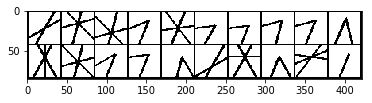

/home/yimengzh/miniconda2/envs/tf15/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


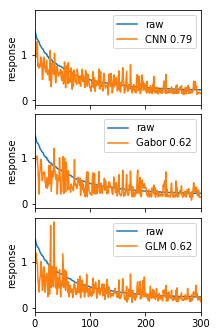

dummy 1 real 33 ccnorm2 0.778625659701 ccabs2 0.714136159908


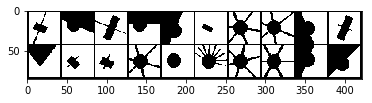

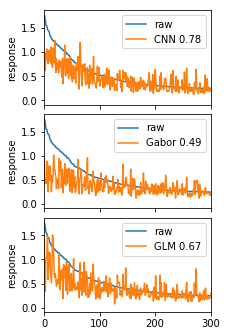

dummy 2 real 103 ccnorm2 0.806855955817 ccabs2 0.712058909154


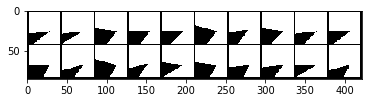

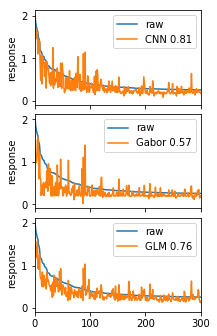

dummy 3 real 415 ccnorm2 0.784509776282 ccabs2 0.709306932649


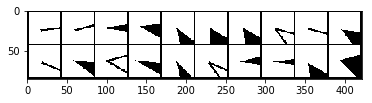

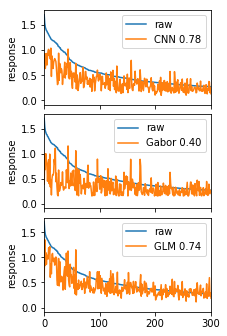

dummy 4 real 1109 ccnorm2 0.79395253624 ccabs2 0.69724009429


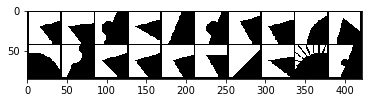

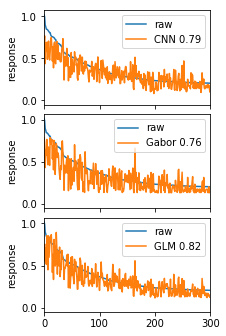

dummy 5 real 797 ccnorm2 0.810671876604 ccabs2 0.682958406551


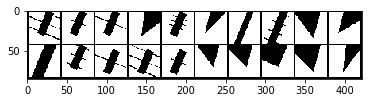

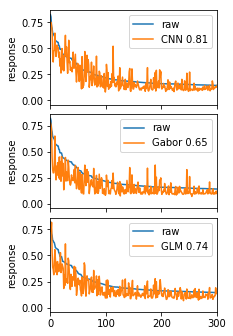

dummy 6 real 356 ccnorm2 0.790719249845 ccabs2 0.68157259462


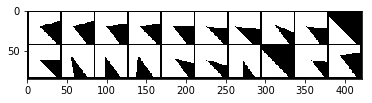

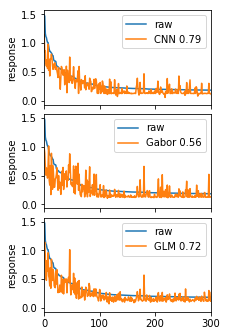

dummy 7 real 578 ccnorm2 0.755995542501 ccabs2 0.677050028799


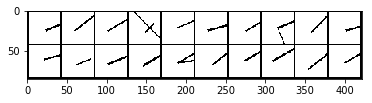

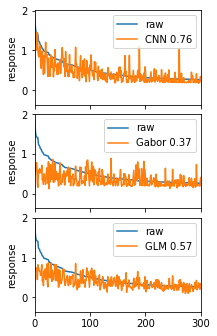

========starting phase 1/1==========
========starting epoch 1000==========
val metric
 {'neg_corr': -0.83118933, 'corr': 0.83118933, 'mse': 0.010041711}
test metric
 {'neg_corr': -0.81184387, 'corr': 0.81184387, 'mse': 0.009637299}
========done epoch 1000==========
========starting epoch 2000==========
val metric
 {'neg_corr': -0.83582455, 'corr': 0.83582455, 'mse': 0.0087083969}
test metric
 {'neg_corr': -0.82380795, 'corr': 0.82380795, 'mse': 0.0082064681}
========done epoch 2000==========
========starting epoch 3000==========
val metric
 {'neg_corr': -0.84209049, 'corr': 0.84209049, 'mse': 0.0083171204}
test metric
 {'neg_corr': -0.82190669, 'corr': 0.82190669, 'mse': 0.0083474815}
========done epoch 3000==========
========starting epoch 4000==========
val metric
 {'neg_corr': -0.84269542, 'corr': 0.84269542, 'mse': 0.0083777048}
test metric
 {'neg_corr': -0.83138663, 'corr': 0.83138663, 'mse': 0.0079295179}
========done epoch 4000==========
========starting epoch 5000==========
val

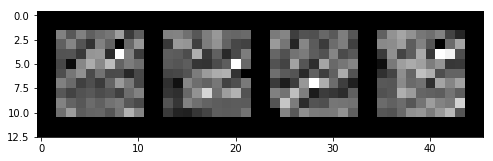

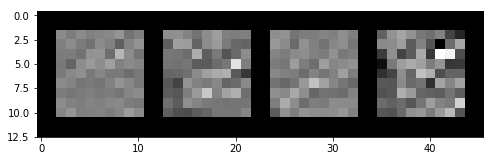

dummy 8 real 114 ccnorm2 0.752512188815 ccabs2 0.663235252665


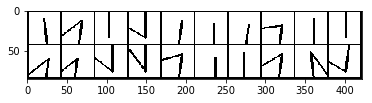

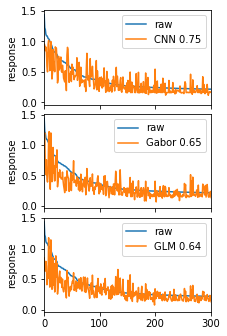

dummy 9 real 637 ccnorm2 0.738459858885 ccabs2 0.649050402741


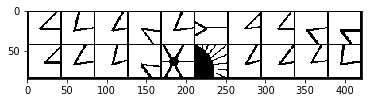

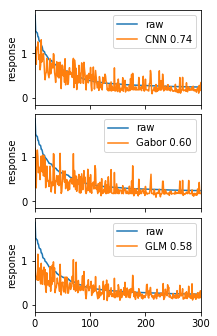

CV 59
0.876581029443
0.941671537113
dummy 0 real 448 ccnorm2 0.77485609564 ccabs2 0.589684583679


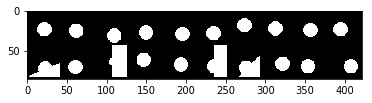

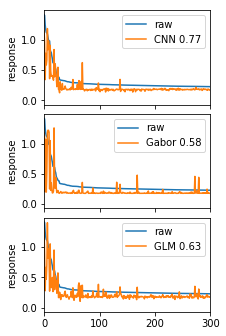

dummy 1 real 1134 ccnorm2 0.658946600219 ccabs2 0.552248971592


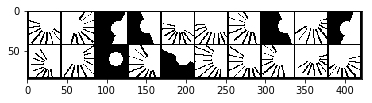

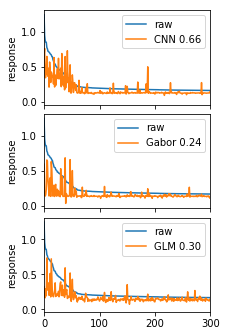

dummy 2 real 351 ccnorm2 0.640673039085 ccabs2 0.50079004237


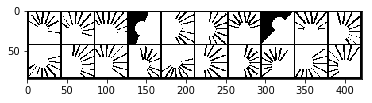

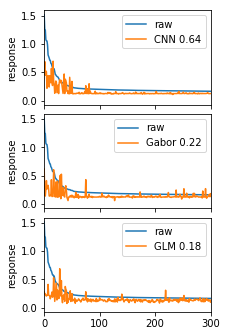

dummy 3 real 838 ccnorm2 0.674577453949 ccabs2 0.499623935149


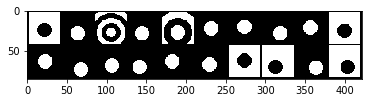

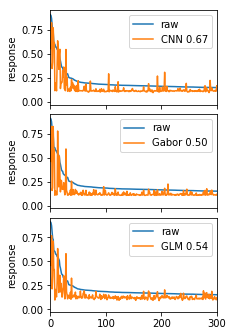

dummy 4 real 323 ccnorm2 0.602390668145 ccabs2 0.482403231903


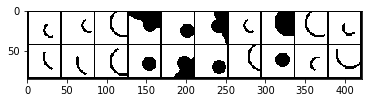

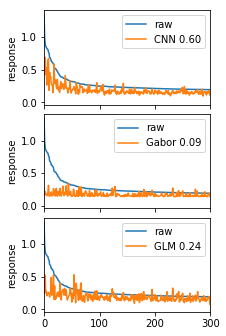

dummy 5 real 553 ccnorm2 0.608118057078 ccabs2 0.456643321834


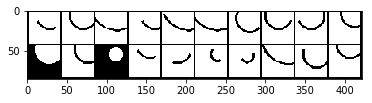

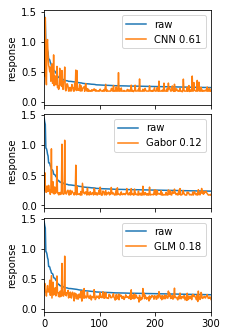

========starting phase 1/1==========
========starting epoch 1000==========
val metric
 {'neg_corr': -0.50087142, 'corr': 0.50087142, 'mse': 0.0056876359}
test metric
 {'neg_corr': -0.48178706, 'corr': 0.48178706, 'mse': 0.0059664664}
========done epoch 1000==========
========starting epoch 2000==========
val metric
 {'neg_corr': -0.57883465, 'corr': 0.57883465, 'mse': 0.0050870827}
test metric
 {'neg_corr': -0.56199622, 'corr': 0.56199622, 'mse': 0.0054245014}
========done epoch 2000==========
========starting epoch 3000==========
val metric
 {'neg_corr': -0.66509664, 'corr': 0.66509664, 'mse': 0.0043529035}
test metric
 {'neg_corr': -0.63846266, 'corr': 0.63846266, 'mse': 0.0046236636}
========done epoch 3000==========
========starting epoch 4000==========
val metric
 {'neg_corr': -0.65819037, 'corr': 0.65819037, 'mse': 0.0042943177}
test metric
 {'neg_corr': -0.64685243, 'corr': 0.64685243, 'mse': 0.0045310701}
========done epoch 4000==========
========starting epoch 5000==========
v

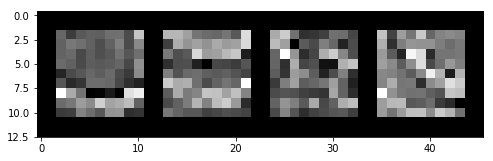

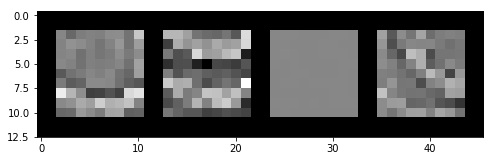

dummy 6 real 275 ccnorm2 0.948215071993 ccabs2 0.445223646186


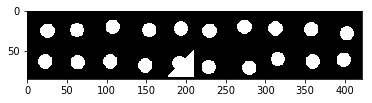

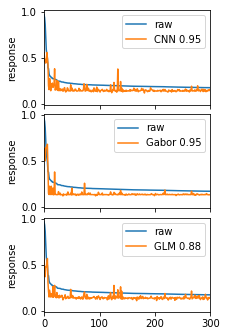

dummy 7 real 9 ccnorm2 0.617663630221 ccabs2 0.422624420742


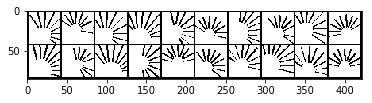

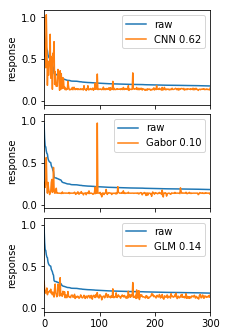

dummy 8 real 857 ccnorm2 0.669729090703 ccabs2 0.404603108156


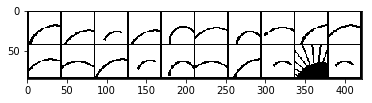

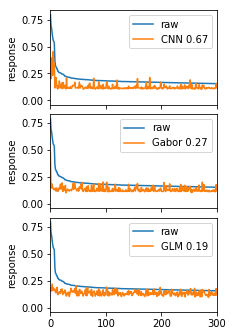

dummy 9 real 2 ccnorm2 0.715113226792 ccabs2 0.350246963483


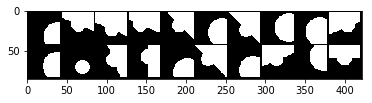

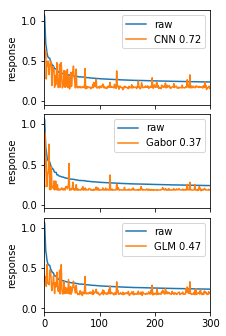

CN 77
0.911263246412
0.952941795047
dummy 0 real 920 ccnorm2 0.818816756917 ccabs2 0.703190745902


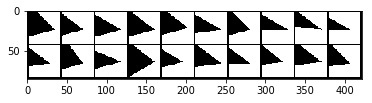

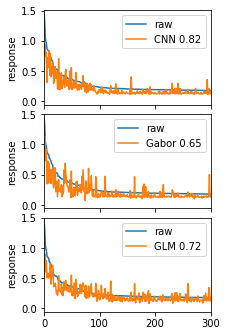

dummy 1 real 459 ccnorm2 0.788135774817 ccabs2 0.645926264939


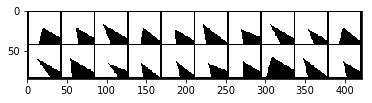

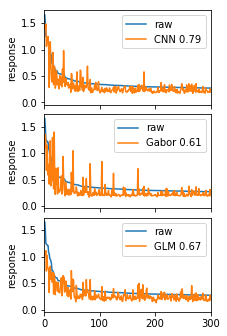

========starting phase 1/1==========
========starting epoch 1000==========
val metric
 {'neg_corr': -0.82380038, 'corr': 0.82380038, 'mse': 0.0051715947}
test metric
 {'neg_corr': -0.79910922, 'corr': 0.79910922, 'mse': 0.0052172816}
========done epoch 1000==========
========starting epoch 2000==========
val metric
 {'neg_corr': -0.83484095, 'corr': 0.83484095, 'mse': 0.0045998525}
test metric
 {'neg_corr': -0.80618554, 'corr': 0.80618554, 'mse': 0.0047903634}
========done epoch 2000==========
========starting epoch 3000==========
val metric
 {'neg_corr': -0.83263129, 'corr': 0.83263129, 'mse': 0.0047069043}
test metric
 {'neg_corr': -0.80145472, 'corr': 0.80145472, 'mse': 0.0049349363}
========done epoch 3000==========
========starting epoch 4000==========
val metric
 {'neg_corr': -0.8282761, 'corr': 0.8282761, 'mse': 0.0049206582}
test metric
 {'neg_corr': -0.80437738, 'corr': 0.80437738, 'mse': 0.0049892445}
========done epoch 4000==========
early stopping after epoch 4200
========e

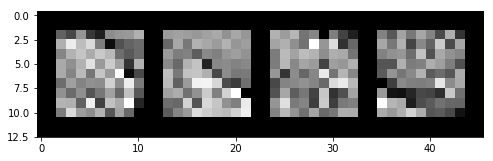

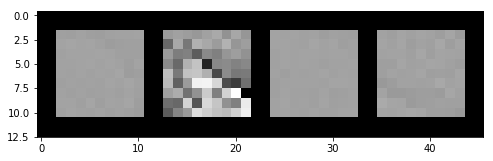

dummy 2 real 274 ccnorm2 0.723796358819 ccabs2 0.59960664142


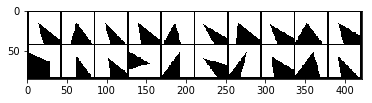

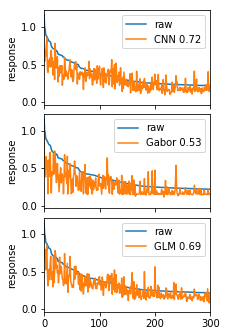

dummy 3 real 501 ccnorm2 0.671970530651 ccabs2 0.585950568743


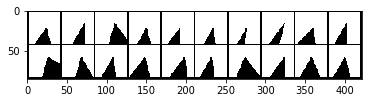

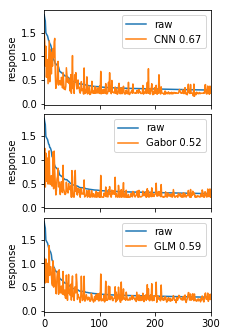

dummy 4 real 791 ccnorm2 0.700089905444 ccabs2 0.542954369085


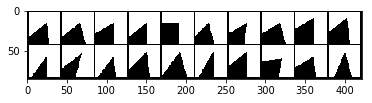

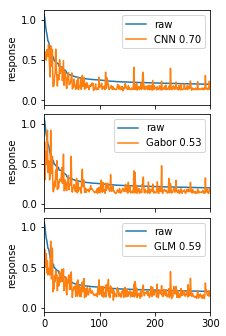

dummy 5 real 1117 ccnorm2 0.595568131845 ccabs2 0.540162725837


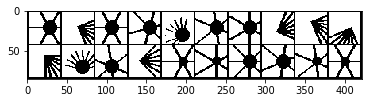

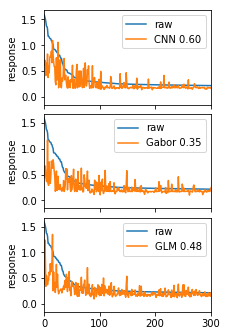

dummy 6 real 521 ccnorm2 0.695086272097 ccabs2 0.515226431098


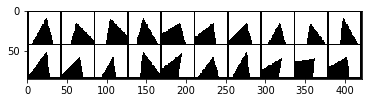

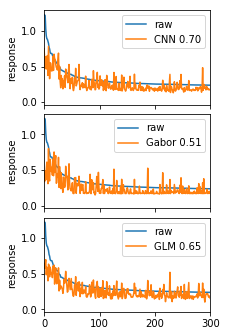

dummy 7 real 1064 ccnorm2 0.754556391976 ccabs2 0.498256036663


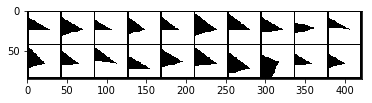

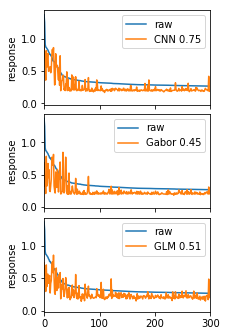

dummy 8 real 642 ccnorm2 0.744207037234 ccabs2 0.497335141841


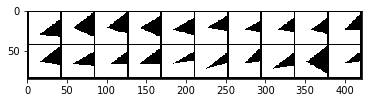

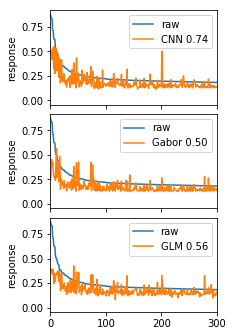

dummy 9 real 1015 ccnorm2 0.699742566136 ccabs2 0.480213998909


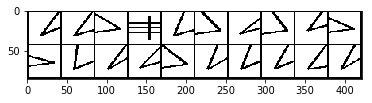

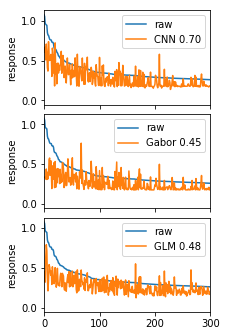

CRS 16
0.922082956049
0.944117647059
dummy 0 real 1079 ccnorm2 0.722829634453 ccabs2 0.480660108605


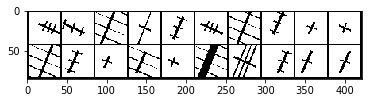

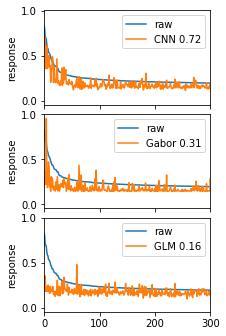

========starting phase 1/1==========
========starting epoch 1000==========
val metric
 {'neg_corr': -0.64511019, 'corr': 0.64511019, 'mse': 0.0028379904}
test metric
 {'neg_corr': -0.58036548, 'corr': 0.58036548, 'mse': 0.002545563}
========done epoch 1000==========
========starting epoch 2000==========
val metric
 {'neg_corr': -0.73690939, 'corr': 0.73690939, 'mse': 0.0022563692}
test metric
 {'neg_corr': -0.67720968, 'corr': 0.67720968, 'mse': 0.0020847765}
========done epoch 2000==========
========starting epoch 3000==========
val metric
 {'neg_corr': -0.75727665, 'corr': 0.75727665, 'mse': 0.0021405339}
test metric
 {'neg_corr': -0.68902695, 'corr': 0.68902695, 'mse': 0.0020480638}
========done epoch 3000==========
========starting epoch 4000==========
val metric
 {'neg_corr': -0.75302011, 'corr': 0.75302011, 'mse': 0.0021345979}
test metric
 {'neg_corr': -0.68957323, 'corr': 0.68957323, 'mse': 0.0020102474}
========done epoch 4000==========
========starting epoch 5000==========
va

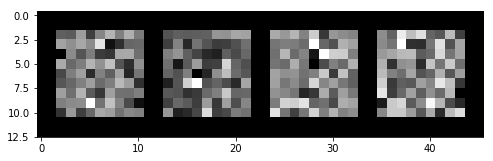

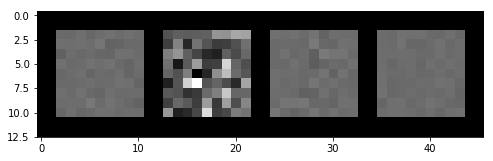

dummy 1 real 36 ccnorm2 0.505062654345 ccabs2 0.354077878518


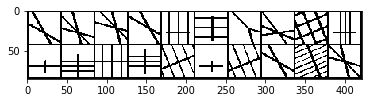

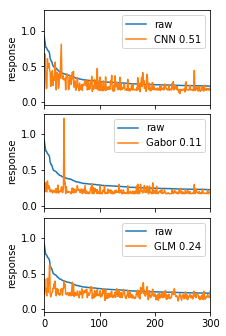

dummy 2 real 119 ccnorm2 0.727621956131 ccabs2 0.306627090654


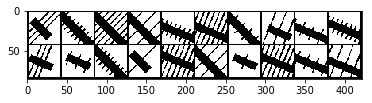

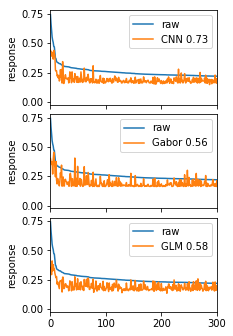

dummy 3 real 882 ccnorm2 0.718490059749 ccabs2 0.290312763495


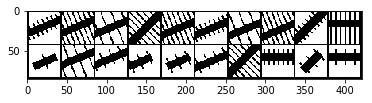

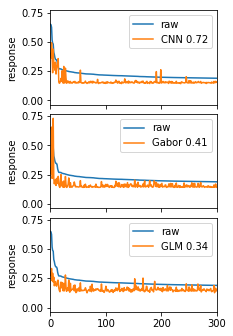

dummy 4 real 986 ccnorm2 0.461058825681 ccabs2 0.26377748207


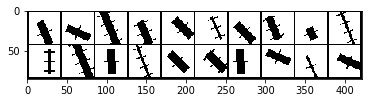

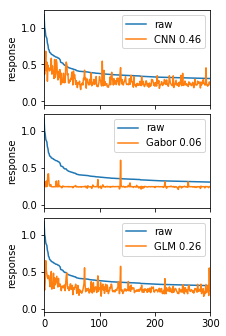

dummy 5 real 813 ccnorm2 0.555684479974 ccabs2 0.241510078952


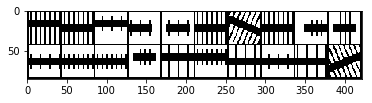

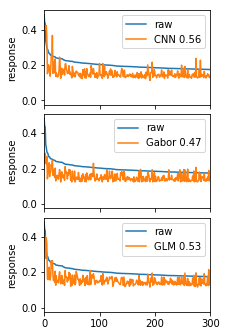

dummy 6 real 898 ccnorm2 0.467063266735 ccabs2 0.19640092661


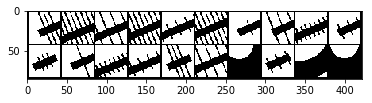

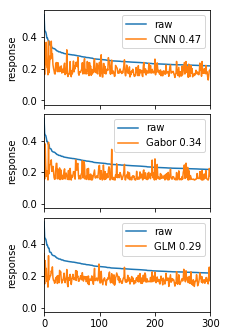

dummy 7 real 464 ccnorm2 0.398703784541 ccabs2 0.177610020168


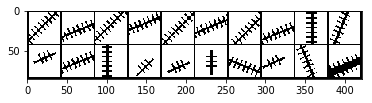

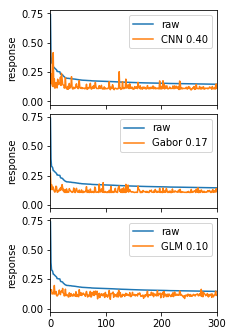

dummy 8 real 761 ccnorm2 0.293922316442 ccabs2 0.130442128399


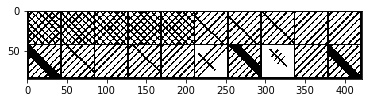

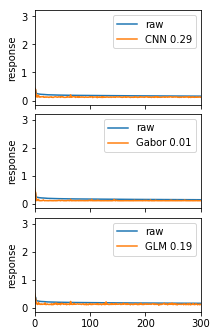

dummy 9 real 167 ccnorm2 0.25978197633 ccabs2 0.129518655575


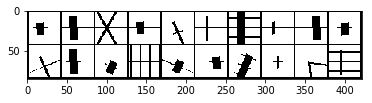

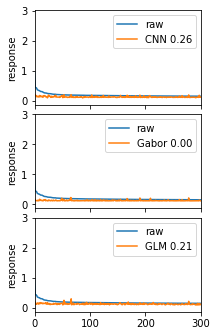

Other 49
0.93239674697
0.955102040816
dummy 0 real 4 ccnorm2 0.762831307754 ccabs2 0.576933549973


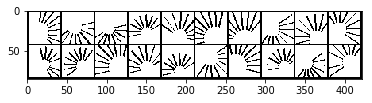

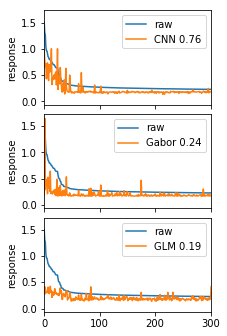

========starting phase 1/1==========
========starting epoch 1000==========
val metric
 {'neg_corr': -0.71432322, 'corr': 0.71432322, 'mse': 0.0040563652}
test metric
 {'neg_corr': -0.77195847, 'corr': 0.77195847, 'mse': 0.0036146699}
========done epoch 1000==========
========starting epoch 2000==========
val metric
 {'neg_corr': -0.71615064, 'corr': 0.71615064, 'mse': 0.0040035341}
test metric
 {'neg_corr': -0.77579993, 'corr': 0.77579993, 'mse': 0.0035996626}
========done epoch 2000==========
early stopping after epoch 2900
========end phase 1/1==========
34.409669399261475 sec
ref corr 0.759561 current corr 0.780784
conv.conv0.weight torch.Size([4, 1, 9, 9])
conv.conv0.bias torch.Size([4])
fc.fc.weight torch.Size([1, 64])
fc.fc.bias torch.Size([1])


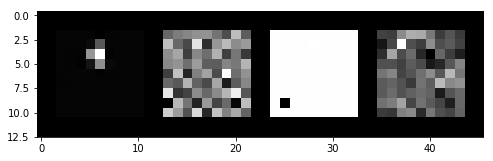

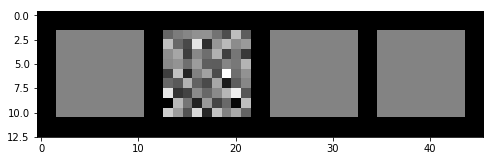

dummy 1 real 819 ccnorm2 0.733917954304 ccabs2 0.486980880773


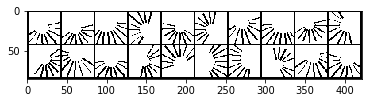

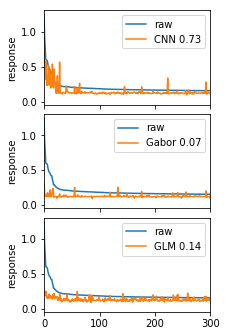

dummy 2 real 979 ccnorm2 0.739903169532 ccabs2 0.450262122577


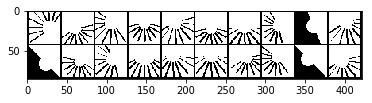

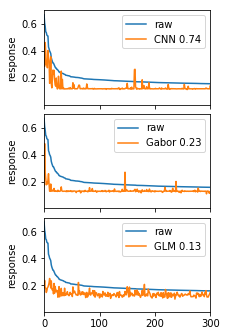

dummy 3 real 0 ccnorm2 0.661142551673 ccabs2 0.437360265579


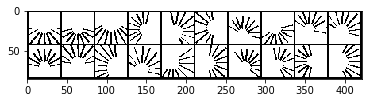

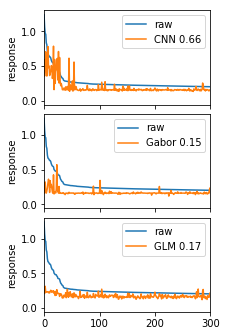

dummy 4 real 215 ccnorm2 0.728106216934 ccabs2 0.42635941129


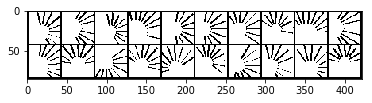

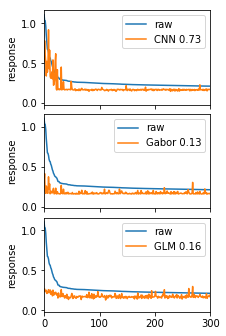

dummy 5 real 9 ccnorm2 0.617663630221 ccabs2 0.422624420742


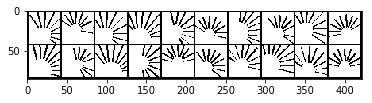

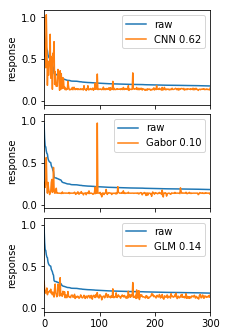

dummy 6 real 906 ccnorm2 0.536193609006 ccabs2 0.421208103543


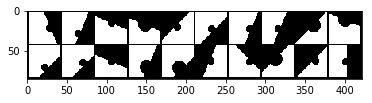

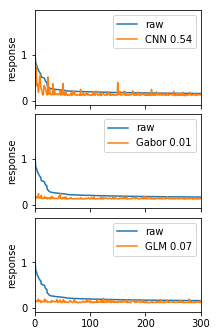

dummy 7 real 1135 ccnorm2 0.707569369976 ccabs2 0.397912862125


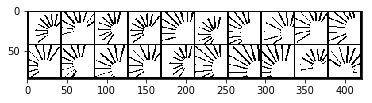

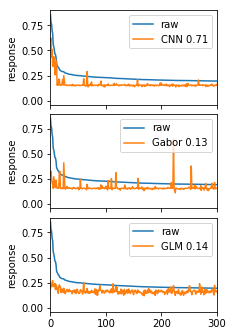

dummy 8 real 796 ccnorm2 0.511300347025 ccabs2 0.336505152907


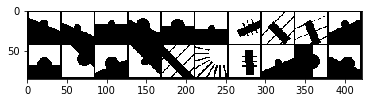

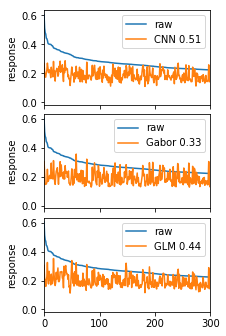

dummy 9 real 1114 ccnorm2 0.553490106884 ccabs2 0.314948275293


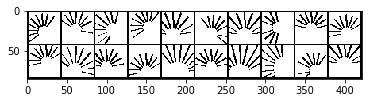

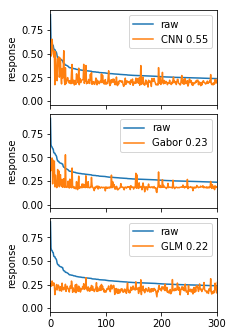

In [13]:
master_loop()